In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bank-additional-full.csv',sep=';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.shape

(41188, 21)

In [6]:
df.isna().sum().sort_values(ascending=False)

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [7]:
categorical_cols = [c for c in df.columns if c!='y' and df[c].dtype == 'object']

In [8]:
for c in categorical_cols:
  print(f"column: \n", df[c].value_counts(),"\n")

column: 
 job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64 

column: 
 marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64 

column: 
 education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64 

column: 
 default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64 

column: 
 housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64 

column: 
 loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int6

In [9]:
df['y'].value_counts() #значно переважає один клас

,count
y,
no,36548
yes,4640


# EDA

### Опис числових змінних

In [10]:
numeric_cols = [c for c in df.columns if df[c].dtype != 'object' and c!='duration']

In [11]:
numeric_cols

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

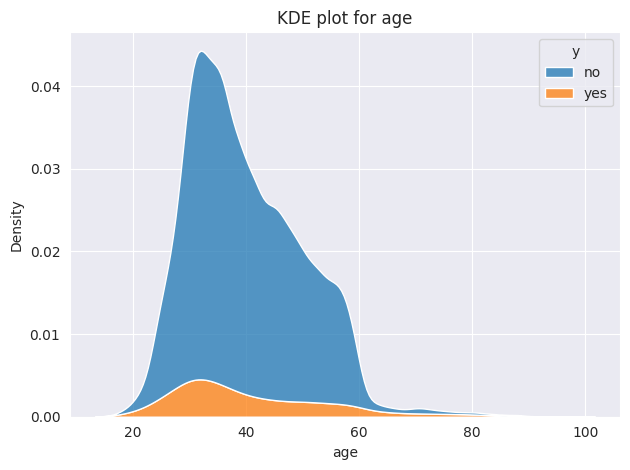

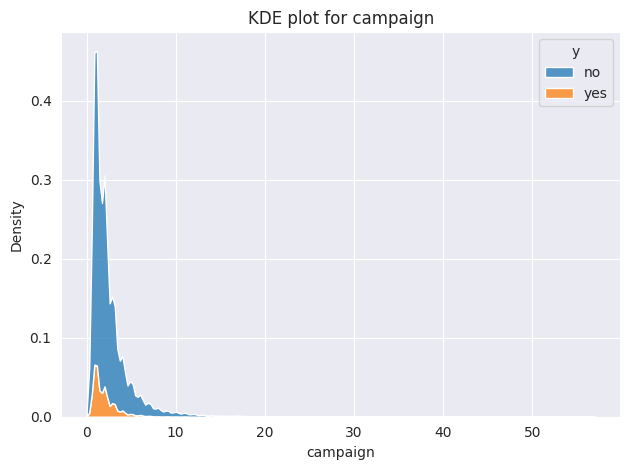

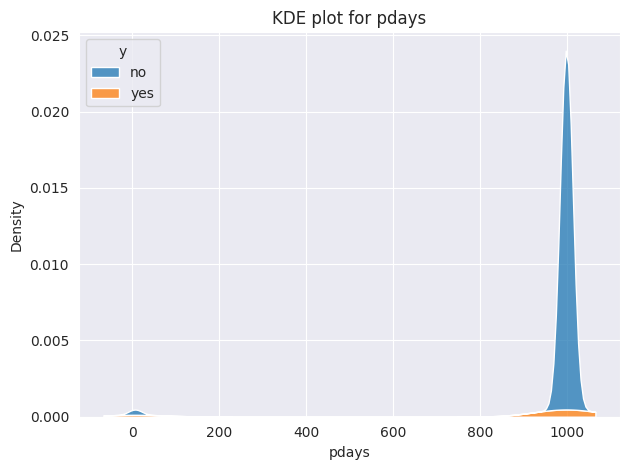

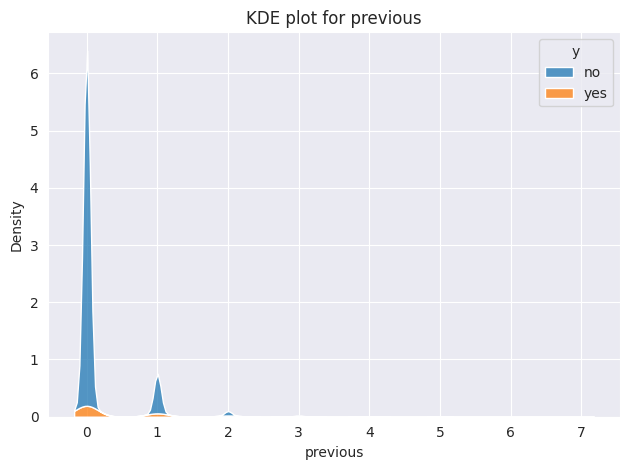

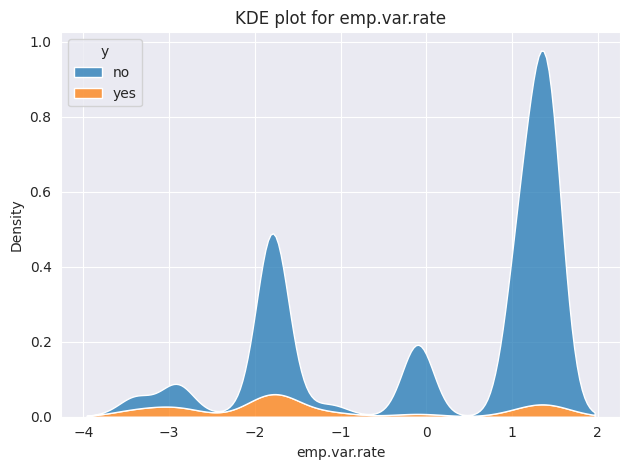

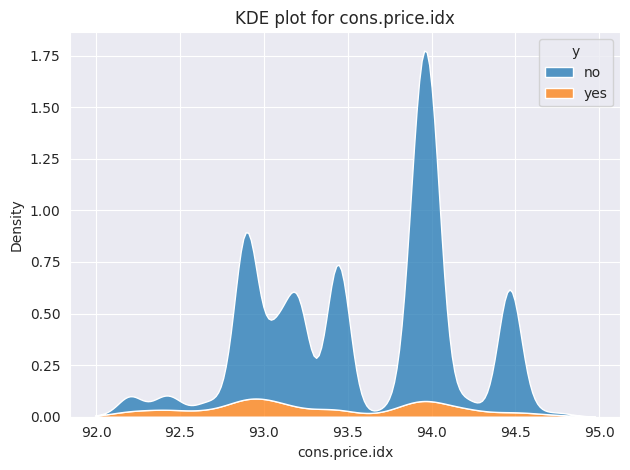

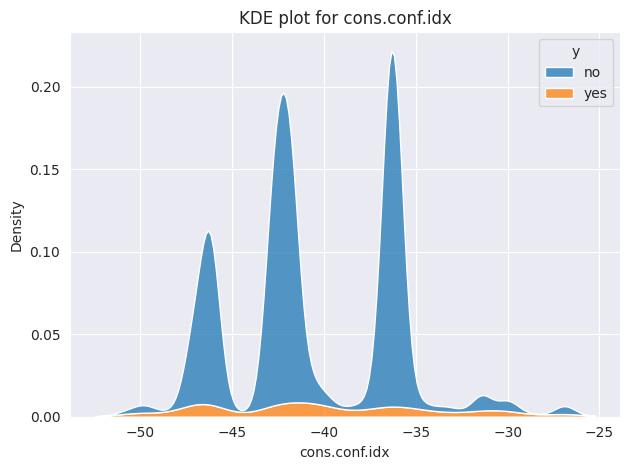

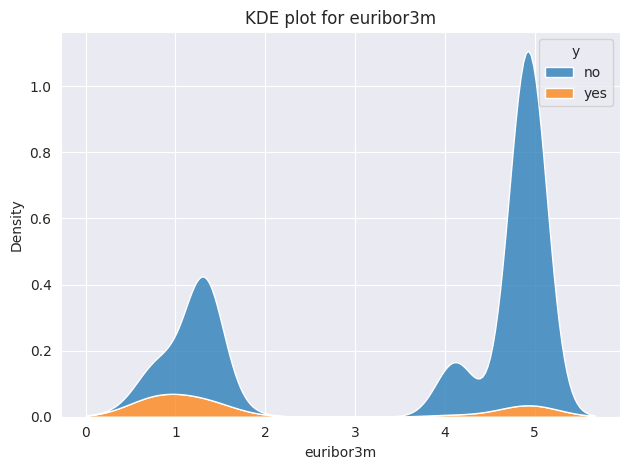

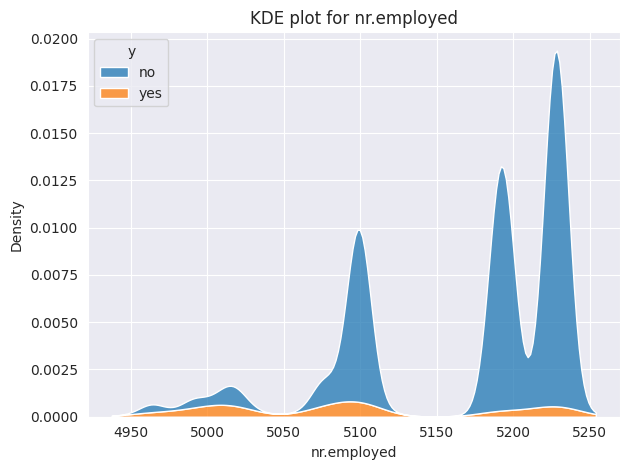

In [12]:
for c in numeric_cols:
  sns.kdeplot(data=df,x=c,hue='y',multiple="stack")
  plt.title(f'KDE plot for {c}')
  plt.tight_layout()
  plt.show()



*   Змінна `cons.conf.idx`,`campaign`,`previous` має викиди,
*   Змінна `pdays` має дуже цікавий розподіл, оскільки число 999 є сталим при ситуації "не контактували" - є сенс перетворити на бінарну змінну був контакт чи ні
* Також змінні `campaign` і `previous` показують, що чимбільше контактів з людиною тим менша ймовірність на підписання депозиту



змінна `duration` дає по суті вже відповідь на запитання, тому вона трохи невдала для навчання моделей

### Опис категоріальних змінних

In [13]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

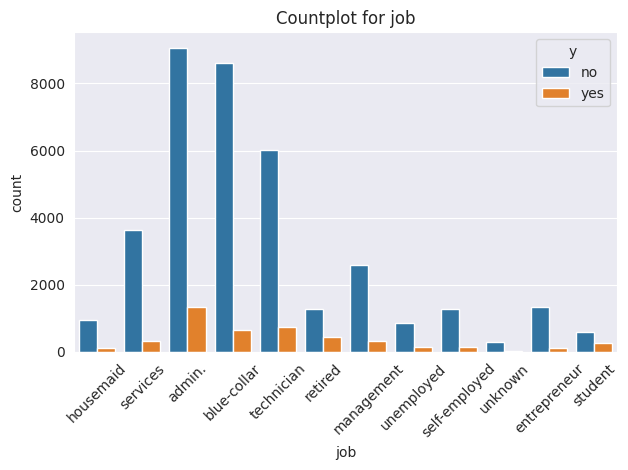

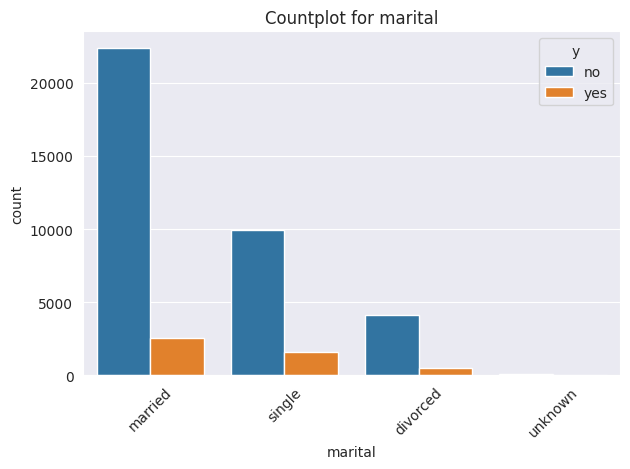

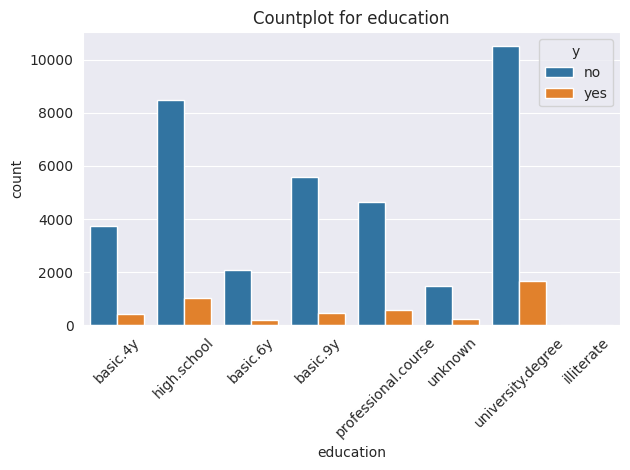

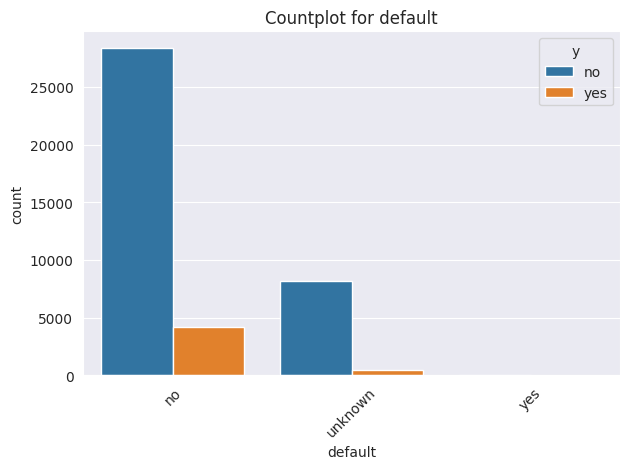

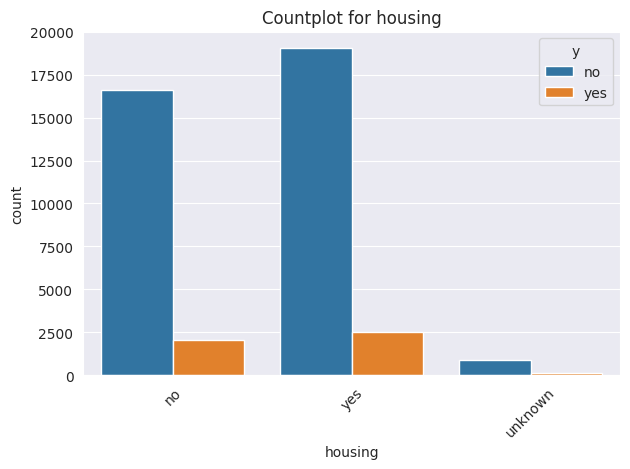

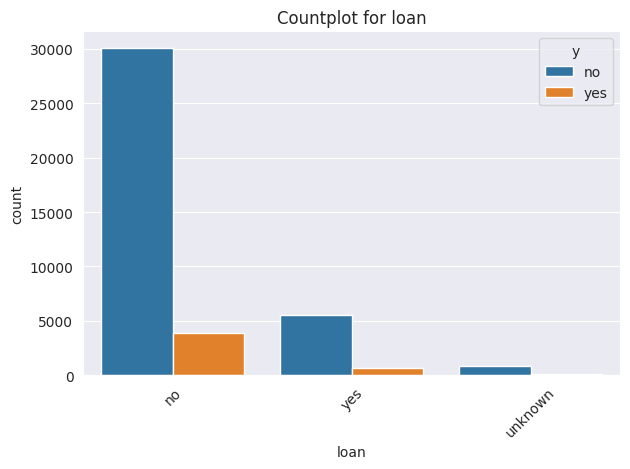

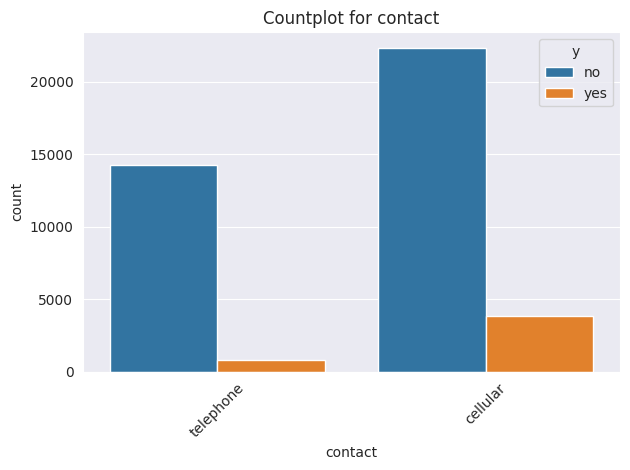

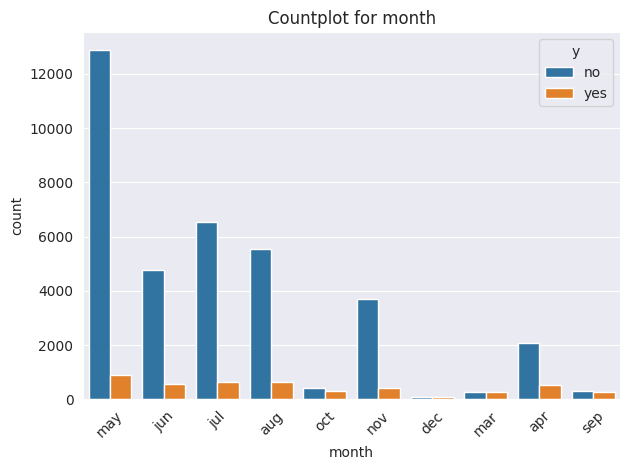

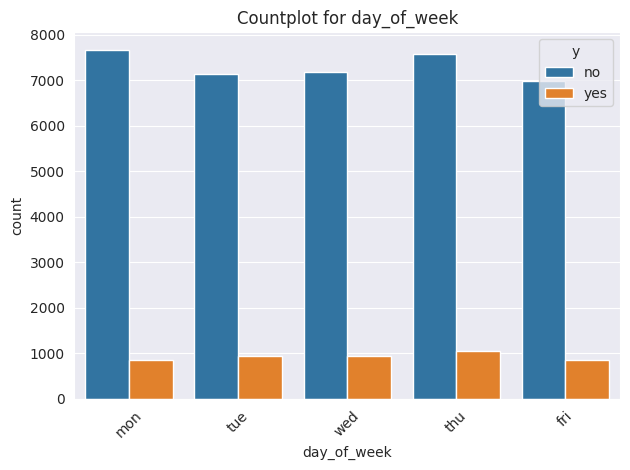

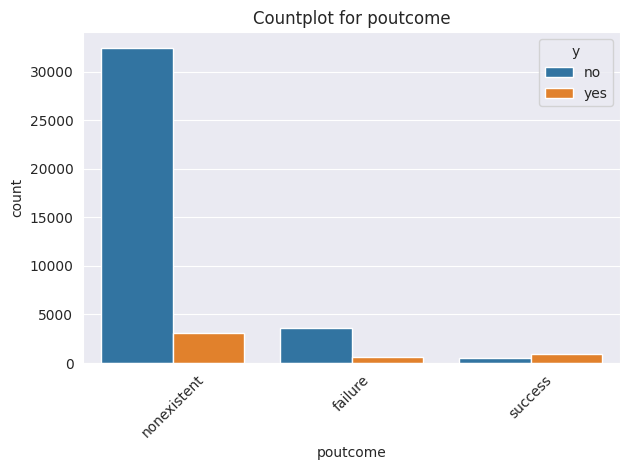

In [19]:
for c in categorical_cols:
  sns.countplot(data=df,x=c,hue='y')
  plt.xticks(rotation=45)
  plt.title(f'Countplot for {c}')
  plt.tight_layout()
  plt.show()

- видно, що переважають одружені клієнти(ті що оформили депозит, і ті що ні)




*   найбільше клієнтів з `university.degree`
*   невідомої категорії трохи так є, тому лишаємо як є - окремою категорією





*   якщо є прострочений кредит, то не беруть депозит






* можна помітити, що дні тижня коли проходила кампанія розподілена рівномірно
* найбільш активний місяць був травень


### Гіпотези


*   як було вказано в умові `duration` впливає на цільову змінну, що логічно бо якщо клієнт зацікавлений в депозиті буде більше питати
*   також на цільову змінну "негативно" вливає `nr.employed`, чим краща екноміка, тим менше людей хоче відкривтаи депозити-кредити
*   також якщо з клієнтом був попередній успішний досвід попередньої кампанії, він більш ймовірно і цього разу "включиться"




# Препроцесінг


### Перетворення цільової колнки у відповідні значення

In [20]:
df['target'] = (df["y"] == "yes").astype(int)

In [21]:
df = df.drop('duration',axis=1)

*викидаю змінну (пояснення було вище)*

## кодування колонок

#### `pdays`

In [22]:
df['previous_contact'] = (df["pdays"] != 999).astype(int)

In [27]:
df['pdays'].replace({999:np.nan},inplace=True)

#### `age`

<Axes: xlabel='age', ylabel='Count'>

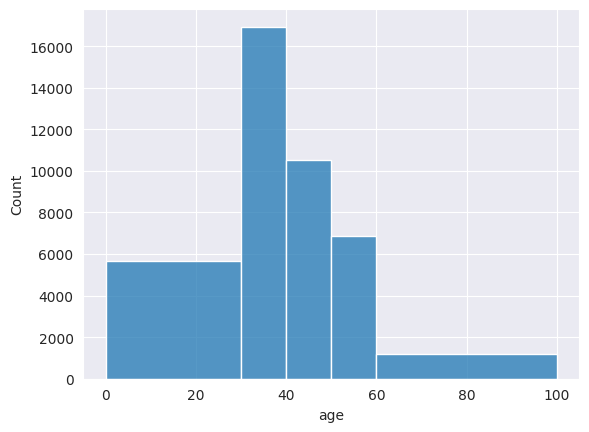

In [50]:
sns.histplot(data=df,x='age',bins=[0,30,40,50,60,100])

In [47]:
df['age_bin'] = pd.cut(df['age'],bins=[0,20,30,40,50,60,100], labels=['20-','21-30','31-40','41-50','51-60','60+'])

In [48]:
df.age_bin.value_counts()

,count
age_bin,
31-40,16385
41-50,10240
21-30,7243
51-60,6270
60+,910
20-,140


### Фільтруємо викиди

In [66]:
def outlier_range(dataset,column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    Min_value = (Q1 - 1.5 * IQR)
    Max_value = (Q3 + 1.5 * IQR)
    return Min_value,Max_value

In [73]:
for c in ['campaign','previous','cons.conf.idx']:
  print(outlier_range(df,c))
  low,up = outlier_range(df,c)
  df[c].clip(lower=low,upper=up,inplace=True)

(np.float64(-2.0), np.float64(6.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(-52.150000000000006), np.float64(-26.949999999999992))


## split data

In [78]:
numeric_cols = [c for c in df.columns if df[c].dtype != 'object' and c!='target'] #перезаписую колонки бо додались нові
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' and c!='y']

In [79]:
numeric_cols, categorical_cols

(['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed',
  'previous_contact',
  'age_bin'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

In [80]:
X = df.drop(['target','y'],axis=1)
Y = df['target']

In [81]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,previous_contact,age_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,31-40
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,31-40
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,51-60


In [82]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [83]:
X_train.shape, X_val.shape, X_test.shape

((28831, 21), (6178, 21), (6179, 21))

## pipeline

In [84]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=True))
])
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Вибір метрики

Для бінарної класифікації є багато варіантів метрик для оцінки якості моделей:

1. Accuracy - відпадає одразу, бо в нас дуже сильно переважає один клас
2. Recall - якщо потрібно не втрати потенційних клієнтів
3. Precision - якщо потрібно не втрачати час на тих хто і так відмовиться
4. F1-score - оскільки це гармонійне середнє між попередніми двома, покаже баланс між цими твердженнями
5. ROC-AUC - дасть змогу загально оцінити якість роботи моделі , як добре розділяє наш таргет


Буду використовувати останні дві для кращої оцінки

In [ ]:
def evaluate_model(model, X,y, model_name):
    '''
    calculates the F1-score and ROC-AUC, and plots the ROC curve.
    '''
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None


    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)

    print(f"🔹 {model_name}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC:  {roc_auc:.4f}")

    # ROC-curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-curve")
    plt.legend()
    plt.show()

    return {"f1_score": f1, "roc_auc": roc_auc}


# Logistic Regression

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [34]:
model_log= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [35]:
param_logistic = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [0, 100]
}

In [37]:
grid_search = GridSearchCV(
    model_log,
    param_logistic,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed',
                                                                          'contact_encod',
                                                                          'housing_encod',
                                                                          'loan_encod']),
                                                                        ('...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [0, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='f1', verbose=2)

In [38]:
best_log_param = grid_search.best_params_
best_log_param

{'classifier__C': 100,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [39]:
best_log_model = grid_search.best_estimator_

🔹 Training (Logistic Regression)
F1-score: 0.3395
ROC-AUC:  0.7932


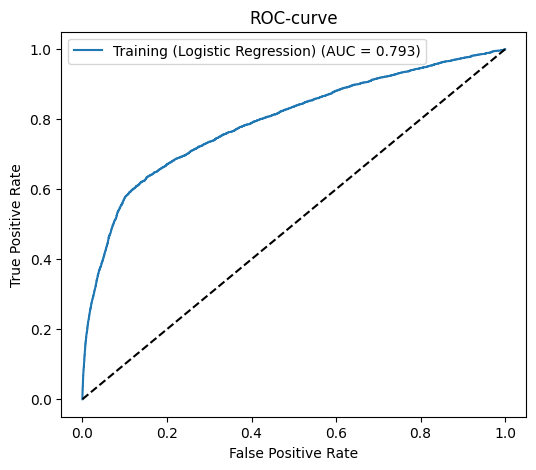

🔹 Testing (Logistic Regression)
F1-score: 0.3374
ROC-AUC:  0.8009


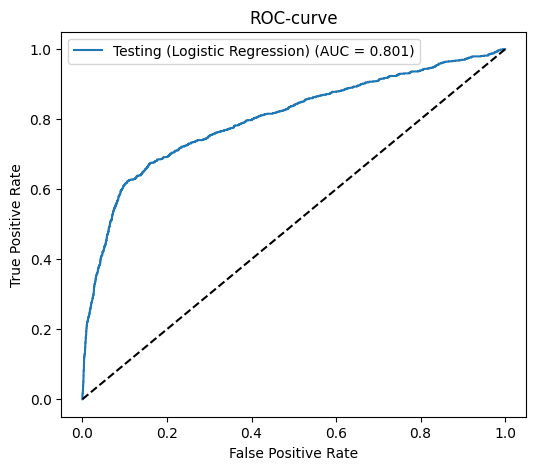

{'f1_score': 0.3374083129584352, 'roc_auc': np.float64(0.800948894995047)}

In [40]:
evaluate_model(best_log_model,X_train,y_train,'Training (Logistic Regression)')
evaluate_model(best_log_model,X_test,y_test,'Testing (Logistic Regression)')

# KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
model_knn= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [43]:
params_knn = {
    'classifier__n_neighbors': np.arange(1, 20)}

In [44]:
knn_gs = GridSearchCV(model_knn, params_knn, cv=3,scoring='f1')
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed',
                                                                          'contact_encod',
                                                                          'housing_encod',
                                                                          'loan_encod']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='f1')

In [45]:
best_knn_param = knn_gs.best_params_
best_knn_param

{'classifier__n_neighbors': np.int64(5)}

In [46]:
best_knn_model = knn_gs.best_estimator_

🔹 Training (KNN)
F1-score: 0.4976
ROC-AUC:  0.9253


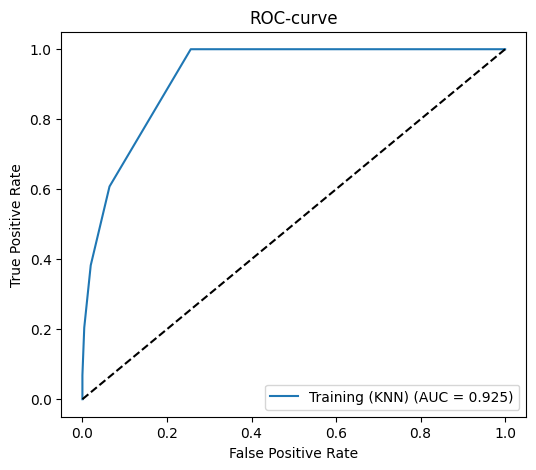

🔹 Testing (KNN)
F1-score: 0.3860
ROC-AUC:  0.7364


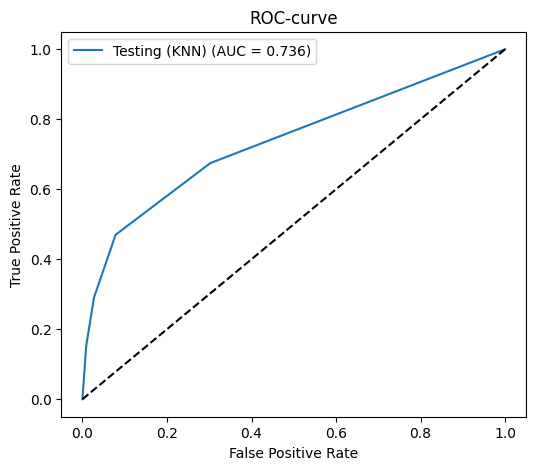

{'f1_score': 0.38598999285203717, 'roc_auc': np.float64(0.7363711142035001)}

In [47]:
evaluate_model(best_knn_model,X_train,y_train,'Training (KNN)')
evaluate_model(best_knn_model,X_test,y_test,'Testing (KNN)')

# Decision Tree

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
model_dt= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [50]:
params_tree = {'classifier__max_depth': np.arange(1, 20,2),
               'classifier__max_leaf_nodes':np.arange(2, 20)}
params_dt = {
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': np.arange(1, 20),
    'classifier__max_leaf_nodes': np.arange(2, 20),
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
}

In [51]:
tree_rs = RandomizedSearchCV(model_dt, params_dt, cv=3,scoring='f1',random_state=42)
tree_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.idx',
                                                                                'cons.conf.idx',
                                                                                'euribor3m',
                                                                                'nr.employed',
                                                                                'contact_encod',
                                                                                'housing_encod',
                                                                                'loan_encod...
                                              DecisionTreeClassifier(random_state=42))]),
                   param_distributions={'classifier__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'classifier__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4, 8],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10,
                                                                          20],
                                        'classifier__splitter': ['best',
                                                                 'random']},
                   random_state=42, scoring='f1')

In [52]:
best_tree_param = tree_rs.best_params_
best_tree_param

{'classifier__splitter': 'best',
 'classifier__min_samples_split': 20,
 'classifier__min_samples_leaf': 1,
 'classifier__max_leaf_nodes': np.int64(19),
 'classifier__max_depth': np.int64(10)}

In [53]:
best_tree_model = tree_rs.best_estimator_

🔹 Training (Tree)
F1-score: 0.3894
ROC-AUC:  0.7880


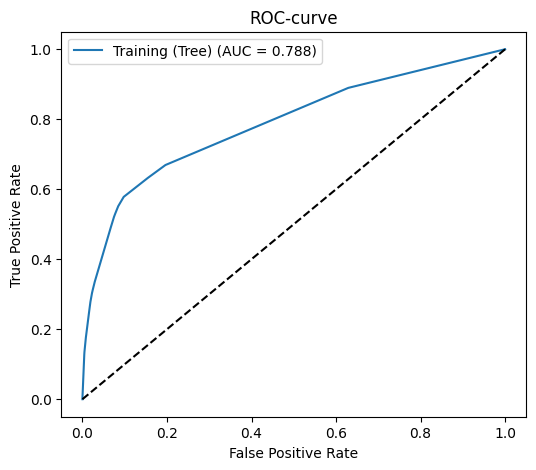

🔹 Testing (Tree)
F1-score: 0.3886
ROC-AUC:  0.7996


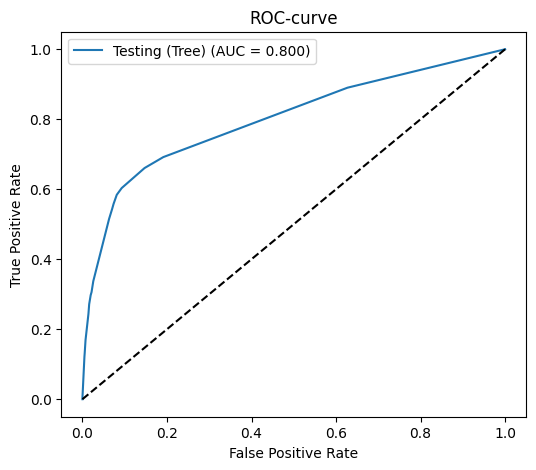

{'f1_score': 0.38858905165767155, 'roc_auc': np.float64(0.7995749357281003)}

In [54]:
evaluate_model(best_tree_model,X_train,y_train,'Training (Tree)')
evaluate_model(best_tree_model,X_test,y_test,'Testing (Tree)')

In [55]:
tree_gs = GridSearchCV(model_dt, params_tree, cv=3,scoring='f1')
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'campaign',
                                                                          'pdays',
                                                                          'previous',
                                                                          'emp.var.rate',
                                                                          'cons.price.idx',
                                                                          'cons.conf.idx',
                                                                          'euribor3m',
                                                                          'nr.employed',
                                                                          'contact_encod',
                                                                          'housing_encod',
                                                                          'loan_encod']),
                                                                        ('...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'classifier__max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             scoring='f1')

In [56]:
best_tree_param_gs = tree_gs.best_params_
best_tree_param_gs

{'classifier__max_depth': np.int64(5),
 'classifier__max_leaf_nodes': np.int64(16)}

🔹 Training (Tree)
F1-score: 0.3825
ROC-AUC:  0.7819


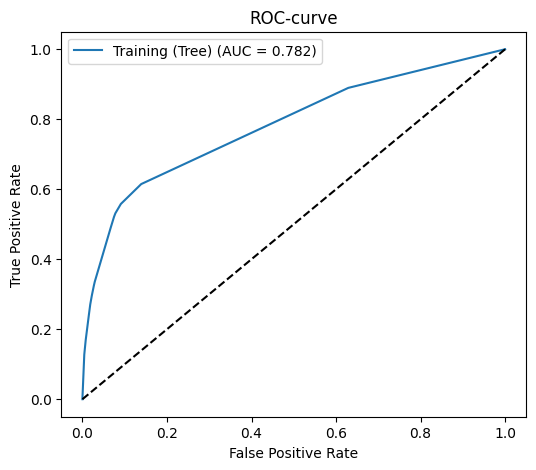

🔹 Testing (Tree)
F1-score: 0.3852
ROC-AUC:  0.7910


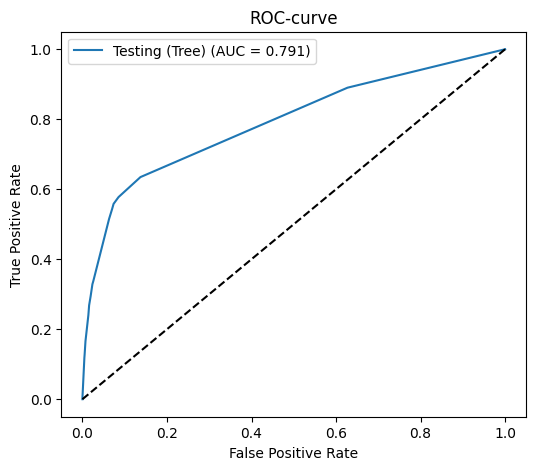

{'f1_score': 0.3851508120649652, 'roc_auc': np.float64(0.7910337751780745)}

In [57]:
best_tree_model_gs = tree_gs.best_estimator_
evaluate_model(best_tree_model_gs,X_train,y_train,'Training (Tree)')
evaluate_model(best_tree_model_gs,X_test,y_test,'Testing (Tree)')

# XGBoost

In [58]:
from xgboost import XGBClassifier

In [59]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import scipy.stats as stats

In [60]:
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
X_test[categorical_cols] = X_test[categorical_cols].astype('category')

## RandomizedSearchCV

In [61]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42)

In [62]:
model_xgb= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

In [63]:
param_xgb_rs = {
    "model__n_estimators": stats.randint(50, 500),
    "model__max_depth": stats.randint(3, 10),
    "model__learning_rate": stats.loguniform(1e-3, 1e-1),
    "model__subsample": stats.uniform(0.5, 0.5),
    "model__colsample_bytree": stats.uniform(0.5, 0.5),
    "model__gamma": stats.loguniform(1e-3, 1.0)
}

In [64]:
search = RandomizedSearchCV(model_xgb,param_distributions=param_xgb_rs,n_iter=30,
    scoring="f1",cv=3,verbose=1,random_state=42,n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'campaign',
                                                                                'pdays',
                                                                                'previous',
                                                                                'emp.var.rate',
                                                                                'cons.price.idx',
                                                                                'cons.conf.idx',
                                                                                'euribor3m',
                                                                                'nr.employed',
                                                                                'contact_encod',
                                                                                'housing_encod',
                                                                                'loan_encod...
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b3f6adc4d40>,
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b3f6aedbb90>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b3f689f75f0>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b3f689f76e0>},
                   random_state=42, scoring='f1', verbose=1)

In [65]:
best_xgb_rs_param = search.best_params_
best_xgb_rs_param

{'model__colsample_bytree': np.float64(0.7699205456508366),
 'model__gamma': np.float64(0.004066152607618112),
 'model__learning_rate': np.float64(0.07686119654652776),
 'model__max_depth': 9,
 'model__n_estimators': 236,
 'model__subsample': np.float64(0.8473924665198522)}

In [66]:
best_xgb_rs_model = search.best_estimator_

🔹 Training (XGBoost)
F1-score: 0.6932
ROC-AUC:  0.9662


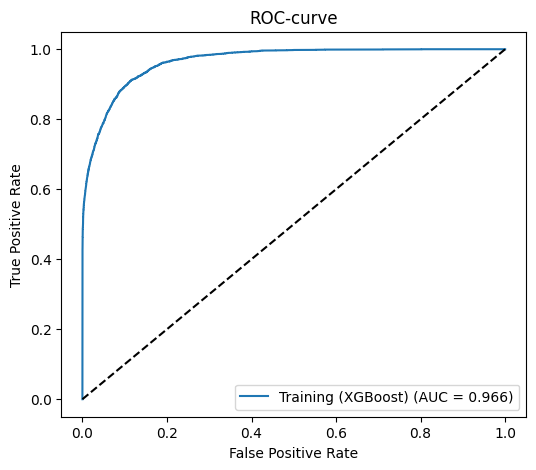

🔹 Testing (XGBoost)
F1-score: 0.4175
ROC-AUC:  0.7993


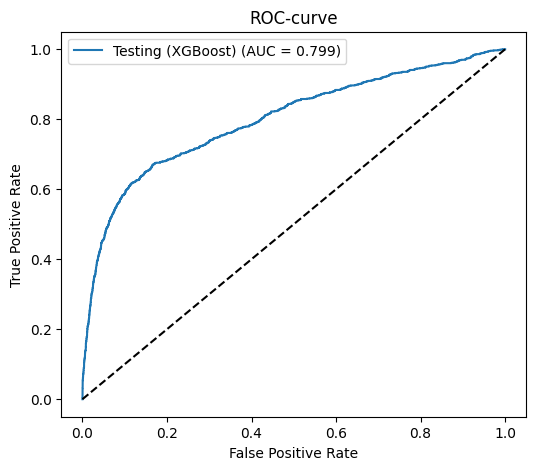

{'f1_score': 0.41750358680057387, 'roc_auc': np.float64(0.799268391197698)}

In [67]:
evaluate_model(best_xgb_rs_model,X_train,y_train,'Training (XGBoost)')
evaluate_model(best_xgb_rs_model,X_test,y_test,'Testing (XGBoost)')

## Hyperopt

In [68]:
def objective(params):
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
                    n_estimators=int(params['n_estimators']),
                    learning_rate=params['learning_rate'],
                    max_depth=int(params['max_depth']),
                    min_child_weight=params['min_child_weight'],
                    subsample=params['subsample'],
                    colsample_bytree=params['colsample_bytree'],
                    gamma=params['gamma'],
                    reg_alpha=params['reg_alpha'],
                    reg_lambda=params['reg_lambda'],
                    enable_categorical=True,
                    use_label_encoder=False,
                    missing=np.nan,
                    eval_metric='auc'))
        ])

    clf.fit(X_train,y_train)

    pred_prob = clf.predict_proba(X_test)
    auroc = roc_auc_score(y_test, pred_prob[:,1])

    return {'loss': -auroc, 'status': STATUS_OK}

In [69]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

In [70]:
trials = Trials()
best_hopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

best_hopt['n_estimators'] = int(best_hopt['n_estimators'])
best_hopt['max_depth'] = int(best_hopt['max_depth'])
best_hopt['min_child_weight'] = int(best_hopt['min_child_weight'])

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



  5%|▌         | 1/20 [00:01<00:22,  1.20s/trial, best loss: -0.7957145679041464]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 10%|█         | 2/20 [00:03<00:37,  2.08s/trial, best loss: -0.8004762901551961]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 15%|█▌        | 3/20 [00:06<00:40,  2.39s/trial, best loss: -0.8004762901551961]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 20%|██        | 4/20 [00:13<01:03,  3.98s/trial, best loss: -0.8004762901551961]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 25%|██▌       | 5/20 [00:16<00:57,  3.84s/trial, best loss: -0.8004762901551961]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 30%|███       | 6/20 [00:17<00:40,  2.92s/trial, best loss: -0.8088556653615737]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 35%|███▌      | 7/20 [00:20<00:39,  3.00s/trial, best loss: -0.8088556653615737]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 40%|████      | 8/20 [00:22<00:32,  2.69s/trial, best loss: -0.8148176211142035]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 45%|████▌     | 9/20 [00:25<00:30,  2.78s/trial, best loss: -0.8148176211142035]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 50%|█████     | 10/20 [00:27<00:22,  2.25s/trial, best loss: -0.8148176211142035]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 55%|█████▌    | 11/20 [00:28<00:17,  1.97s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 60%|██████    | 12/20 [00:30<00:15,  1.94s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 65%|██████▌   | 13/20 [00:33<00:15,  2.21s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 70%|███████   | 14/20 [00:38<00:18,  3.05s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 75%|███████▌  | 15/20 [00:40<00:14,  2.99s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 80%|████████  | 16/20 [00:44<00:12,  3.23s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 85%|████████▌ | 17/20 [00:49<00:11,  3.86s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 90%|█████████ | 18/20 [00:50<00:05,  2.90s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 95%|█████████▌| 19/20 [00:53<00:02,  2.88s/trial, best loss: -0.8151650726449361]

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



100%|██████████| 20/20 [00:57<00:00,  2.89s/trial, best loss: -0.8151650726449361]


In [71]:
final_xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier(
        n_estimators=int(best_hopt['n_estimators']),
        learning_rate=float(best_hopt['learning_rate']),
        max_depth=int(best_hopt['max_depth']),
        min_child_weight=float(best_hopt['min_child_weight']),
        subsample=float(best_hopt['subsample']),
        colsample_bytree=float(best_hopt['colsample_bytree']),
        gamma=float(best_hopt['gamma']),
        reg_alpha=float(best_hopt['reg_alpha']),
        reg_lambda=float(best_hopt['reg_lambda']),
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])
final_xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:49:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed',
                                                   'contact_encod',
                                                   'housing_encod',
                                                   'loan_encod']),
                                                 ('cat',
                                                  Pipeline(steps=[('imput...
                               gamma=0.25456213037520553, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02077740506828233, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=6.0,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

🔹 Training (XGBoost)
F1-score: 0.3698
ROC-AUC:  0.8194


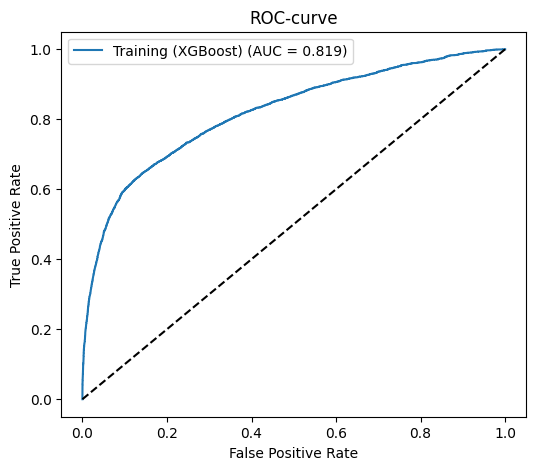

🔹 Testing (XGBoost)
F1-score: 0.3460
ROC-AUC:  0.8163


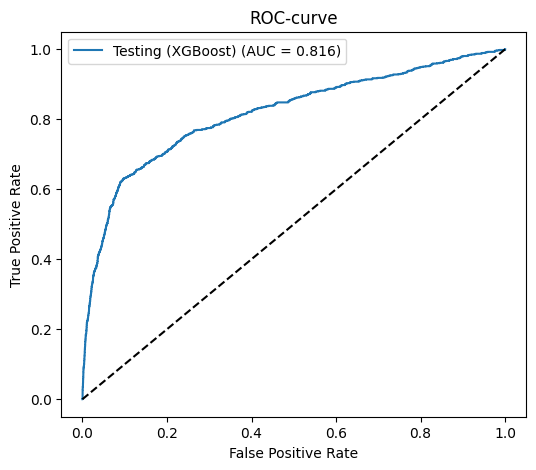

{'f1_score': 0.3459983831851253, 'roc_auc': np.float64(0.8162867352233596)}

In [72]:
evaluate_model(final_xgb_model,X_train,y_train,'Training (XGBoost)')
evaluate_model(final_xgb_model,X_test,y_test,'Testing (XGBoost)')

# Вітаю вас на Mid-term проєкті!

Цей проєкт призначений для того, щоб ви могли оновити та закріпити знання, які ви отримали за перші місяці навчання на курсі "Machine Learning для людей".

### Основна задача

В цьому завданні Ви - Data Scientist в барнку. Ваша задача - побудувати модель для передбачення, чи оформить клієнт в банку строковий депозит (term deposit). З подібними задачами ми стикаємось в різних компаніях і доменах, коли хочемо зрозуміти, чи клієнт купить якийсь продукт, чи буде користуватись нашим сервісом/сайтом у наступному місяці, чи придбає підписку.

Вам треба не просто побудувати модель, а і пояснити замовнику (ваш замовник тут - це ми з кураторами) як працює ця модель і чому вона дає саме такі рішення. Без цього розуміння ми не можемо перейти до впроваждення (деплойменту) моделі в продакшен.

### Практичне застовування

В реальних робочих умовах в подібних задачах у Вас дані будуть зберігатись в базі данних в динаміці (різні дії користувачів з датою і часом). Тут дані вже загреговані по клієнтам і часто саме з цього ви будете починати побудову моделі передбачення, адже це відносно просто і зручно: загрегувати дані по клієнтам до певного часу і передбачати в майбутнє (тільки в випадку тренування моделі ML наше "майбутнє" теж фактично в минулому - бо ми хочемо мати мітки в даних, а от вже при використанні моделі в продакшені і бойових умовах ви справді будете робити передбачення в майбутнє). Тож, розвʼязуємо задачку!

### Датасет і ML задача

Для виконання завдання ми використаємо набір даних, який оригінально походить з сайту [UCI Machine Learning Repository], але там неточний опис даних і багато різних піднаборів, тому ми братимемо з Kaggle dataset: https://www.kaggle.com/datasets/sahistapatel96/bankadditionalfullcsv.

Ці дані стосуються прямих маркетингових кампаній (телефонних дзвінків) португальської банківської установи. Кінцева мета класифікації - передбачити, чи підпише клієнт строковий депозит (змінна y).

Ми будемо працювати з файлом `bank-additional-full.csv`, скачати набір даних треба з Kaggle. Або можна скачати цей самий набір з гугл диска [тут](https://drive.google.com/file/d/1pDr0hAOnu1JsEiJeBu_F2Jv0GPxKiujW/view?usp=drive_link)

### Опис змінних

Цей опис є і на Kaggle, але ми переклали для вашої зручності і аби він був у вас перед очима під час роботи над проєктом.

#### **Дані про клієнта банку**:
1. **age** – вік клієнта (числова змінна).  
2. **job** – вид зайнятості (категоріальна змінна: `admin.`, `blue-collar`, `entrepreneur`, `housemaid`, `management`, `retired`, `self-employed`, `services`, `student`, `technician`, `unemployed`, `unknown`).  
3. **marital** – сімейний стан (категоріальна змінна: `divorced`, `married`, `single`, `unknown`; примітка: `divorced` означає розлучений або вдівець/вдова).  
4. **education** – рівень освіти (категоріальна змінна: `basic.4y`, `basic.6y`, `basic.9y`, `high.school`, `illiterate`, `professional.course`, `university.degree`, `unknown`).  
5. **default** – чи є у клієнта прострочений кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
6. **housing** – чи має клієнт іпотечний кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  
7. **loan** – чи має клієнт споживчий кредит? (категоріальна змінна: `no`, `yes`, `unknown`).  

#### **Дані про останній контакт у межах поточної маркетингової кампанії**:
8. **contact** – тип зв’язку при останньому контакті (категоріальна змінна: `cellular`, `telephone`).  
9. **month** – місяць останнього контакту (категоріальна змінна: `jan`, `feb`, `mar`, …, `nov`, `dec`).  
10. **day_of_week** – день тижня останнього контакту (категоріальна змінна: `mon`, `tue`, `wed`, `thu`, `fri`).  
11. **duration** – тривалість останнього контакту в секундах (числова змінна).  
   ⚠ **Важлива примітка**: ця змінна має суттєвий вплив на цільову змінну (наприклад, якщо duration = 0, то y = `no`). Однак значення duration невідоме до здійснення дзвінка. Крім того, після завершення дзвінка значення y вже відоме. Тому цю змінну варто використовувати лише для порівняння моделей, але не включати у фінальну передбачувальну модель.  

#### **Інші атрибути**:
12. **campaign** – кількість контактів у межах поточної кампанії для цього клієнта (числова змінна, включає останній контакт).  
13. **pdays** – кількість днів, що минули з моменту останнього контакту клієнта у попередній кампанії (числова змінна; значення 999 означає, що клієнт раніше не контактувався).  
14. **previous** – кількість контактів, здійснених до цієї кампанії для цього клієнта (числова змінна).  
15. **poutcome** – результат попередньої маркетингової кампанії (категоріальна змінна: `failure`, `nonexistent`, `success`).  

#### **Атрибути соціально-економічного контексту**:
16. **emp.var.rate** – темп зміни зайнятості (щоквартальний показник, числова змінна).  
17. **cons.price.idx** – індекс споживчих цін (щомісячний показник, числова змінна).  
18. **cons.conf.idx** – індекс довіри споживачів (щомісячний показник, числова змінна).  
19. **euribor3m** – ставка Euribor на 3 місяці (щоденний показник, числова змінна).  
20. **nr.employed** – кількість працевлаштованих осіб (щоквартальний показник, числова змінна).  

#### **Цільова змінна**:
21. **y** – чи підписав клієнт строковий депозит? (бінарна змінна: `yes`, `no`).

### Ваше завдання на цей проєкт

Необхідно побудувати рішення цієї задачі бінарної класифікації. Для цього

1. Провести Exploratory Data Analysis і висунути гіпотези щодо впливу окремих ознак на цільову ознаку `y`.

2. Описати, які методи ви вважаєте доречним використовувати і обрати метрику оцінки якості моделей (метрику треба обґрунтувати).

3. Провести препроцесинг даних для подальшої їх передачі в модель. Препроцесинг має включати
  - обробку категоріальних змінних (якщо цього потребує модель)
  - групування категорій в категоріальних змінних, якщо потрібно
  - заповнення пропущених значень, якщо такі є
  - виявлення outliers і прийняття рішень, що з ними робити
  - створення додаткових ознак, які на ваш погляд поліпшать якість моделей ML.

4. Натренувати 4 різні типи моделей машинного навчання, з яких обовʼязково
  - Logistic Regression
  - kNN
  - Decision Tree
  - Принаймні один з алгоритмів бустингу

5. Створити таблицю з порівнянням якості моделей (в Google Spreadsheets або прямо в Jupyter Notebook), де зазначити
  - назву моделі
  - гіперпараметри
  - метрика якості моделі на тренувальному наборі
  - метрика якості моделі на валідаційному наборі даних
  - коментар до моделі - хороша вона, чи ні, чи варто її використовувати чи ні, чи є у вас подальші ідеї щодо експериментів з цією моделлю?

6. Для алгоритму бустингу виконати процедуру тюнингу гіперпараметрів двома способами
  - Sklearn: Randomized Search
  - Hyperopt: Bayesian Optimization.
  Виявити оптимальні гіперпараметри і зробити висновки про якість моделі в кожному з випадків.

7. Вивести важливість ознак для моделі, які показала себе найкраще і описати, чи вважаєте ви саме такий пріоритет важливості ознак адекватним з точки зору common sense?

8. Для найкращої провести аналіз впливу ознак на передбачення з допомогою бібліотеки SHAP.

9. Провести аналіз записів, в яких модель помиляється і на основі нього зазначити, яким чином можна поліпшити наявне рішення аби уникати наявних помилок?


### Результат виконання проєкту

Результатом виконання цього завдання є окремий github репозиторій з охайно оформленим Jupyter Notebook, частина коду може бути винесена в .py файли. Репозиторій має містити опис задачі, опис що було зроблено і які моделі використано, таблицю результатів експериментів (можна скріншотом або створити таблицю в Markdown форматі - див. Приклад) і висновки, що Ви досягли і що можна було б ще зробити для поліпшення результатів.


### Приклад проєкту

Для натхнення ви можете ознайомитись з проєктом, побудованим на основі цих даних за [цим посиланням](https://github.com/surtantheta/Bank_Marketing_Dataset_Machine_Learning_Project).




![](https://blogconcept2competence.wordpress.com/wp-content/uploads/2014/03/yoda.jpg)

In [73]:
best_log_param

{'classifier__C': 100,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [81]:
comp_data = {
    'Model':['Logistic Regression','KNN','Decision Tree','XGBoost:RandomizedSearchCV','XGBoost:Hyperopt'],
    'Hyperparams':[best_log_param,best_knn_param,best_tree_param, best_xgb_rs_param,best_hopt],
    'ROC-curve on Train':[0.7932,0.9253,0.7880,0.9662,0.8194],
    'ROC-curve on Test':[0.8009,0.7364,0.7996,0.7993,0.8163]
}
comp_df = pd.DataFrame(comp_data)

In [82]:
comp_df

,Model,Hyperparams,ROC-curve on Train,ROC-curve on Test
0,Logistic Regression,"{'classifier__C': 100, 'classifier__max_iter':...",0.7932,0.8009
1,KNN,{'classifier__n_neighbors': 5},0.9253,0.7364
2,Decision Tree,"{'classifier__splitter': 'best', 'classifier__...",0.7880,0.7996
3,XGBoost:RandomizedSearchCV,{'model__colsample_bytree': 0.7699205456508366...,0.9662,0.7993
4,XGBoost:Hyperopt,"{'colsample_bytree': 0.6568186973864494, 'gamm...",0.8194,0.8163


**коментар до моделі - хороша вона, чи ні, чи варто її використовувати чи ні, чи є у вас подальші ідеї щодо експериментів з цією моделлю?**

In [84]:
?final_xgb_model

In [91]:
xgb_model = final_xgb_model.named_steps["model"]
feature_names = final_xgb_model.named_steps["preprocessor"].get_feature_names_out()
importances = xgb_model.feature_importances_

# робимо табличку
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feat_imp.head(10)

,feature,importance
8,num__nr.employed,0.350563
4,num__emp.var.rate,0.071382
56,cat__poutcome_success,0.067743
2,num__pdays,0.056666
7,num__euribor3m,0.049428
6,num__cons.conf.idx,0.036469
44,cat__month_mar,0.029661
47,cat__month_oct,0.025834
45,cat__month_may,0.023830
5,num__cons.price.idx,0.019500


#WAY 2

In [92]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [94]:
df.shape

(41188, 21)

In [95]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## eda 2

In [96]:
df.isna().sum().sort_values(ascending=False)

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [99]:
cat_cols_raw = [c for c in df.columns if df[c].dtype == 'object' and c != 'y']
for c in cat_cols_raw:
  vals = df[c].value_counts(dropna=False)
  print(f"\n[{c}] {len(vals)} категорій")
  print(vals.head(20))


[job] 12 категорій
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

[marital] 4 категорій
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

[education] 8 категорій
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

[default] 3 категорій
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

[housing] 3 категорій
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

[loan] 3 категорій
loan
no         

In [100]:
df['y'].value_counts()

,count
y,
no,36548
yes,4640


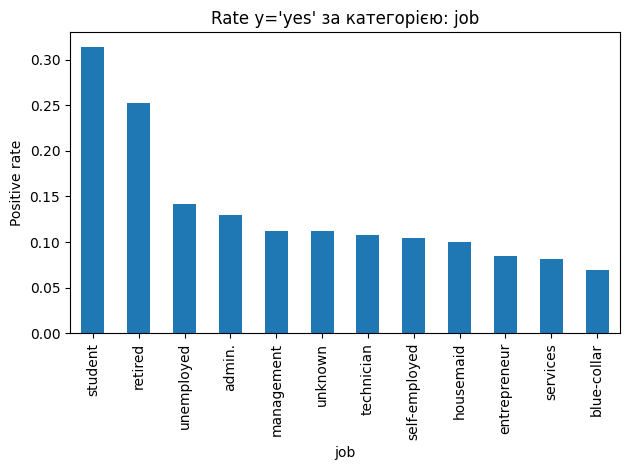

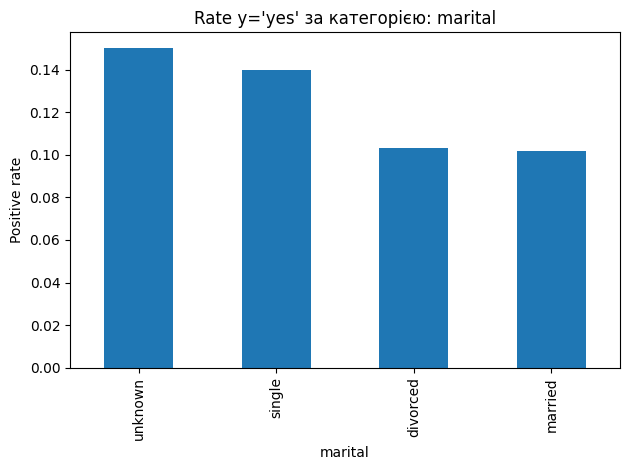

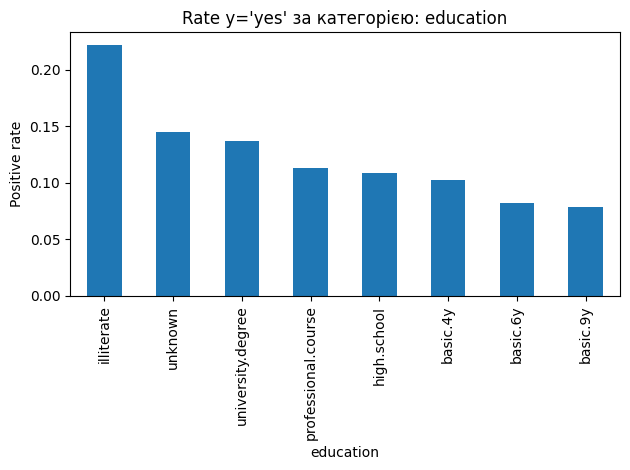

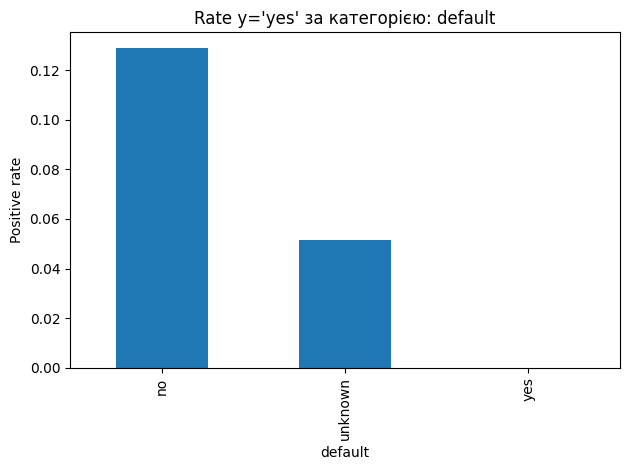

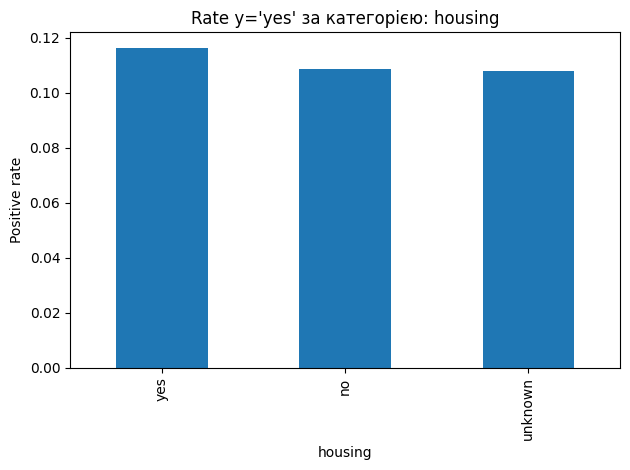

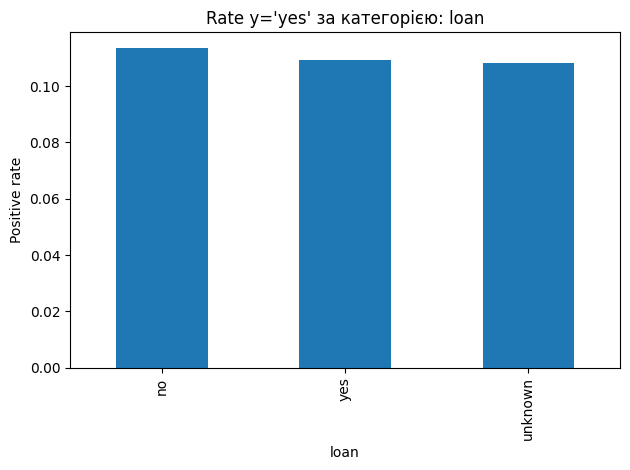

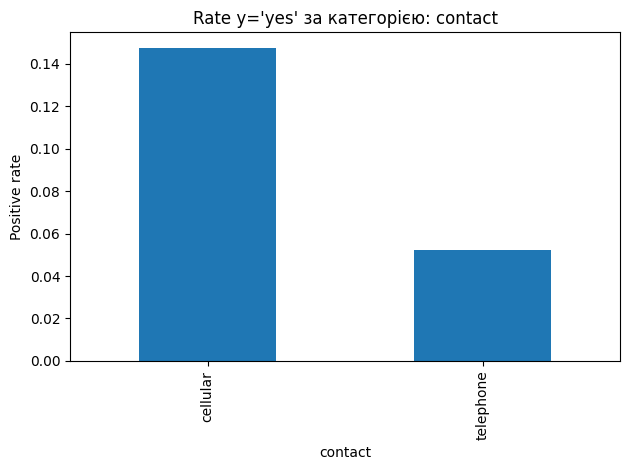

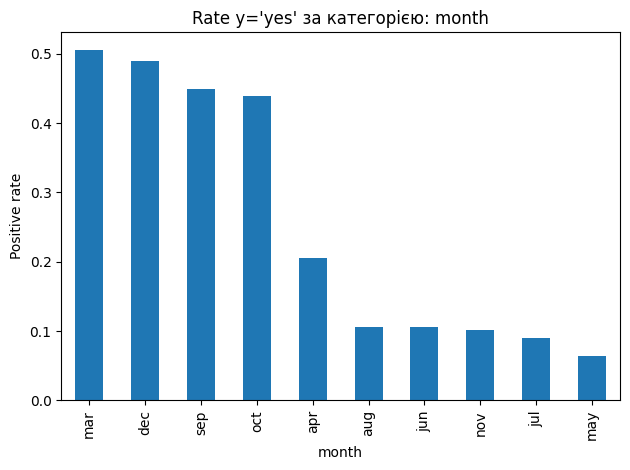

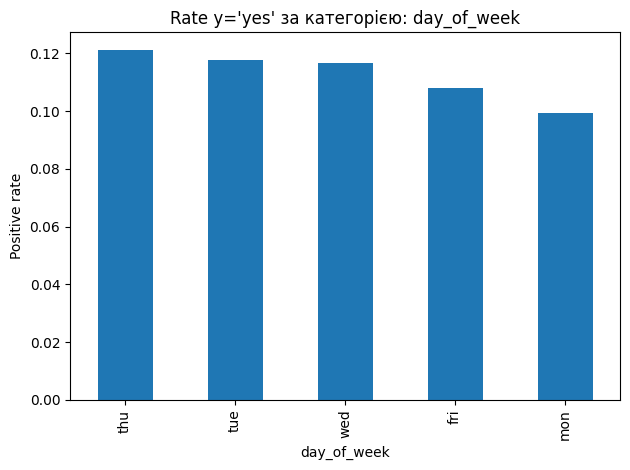

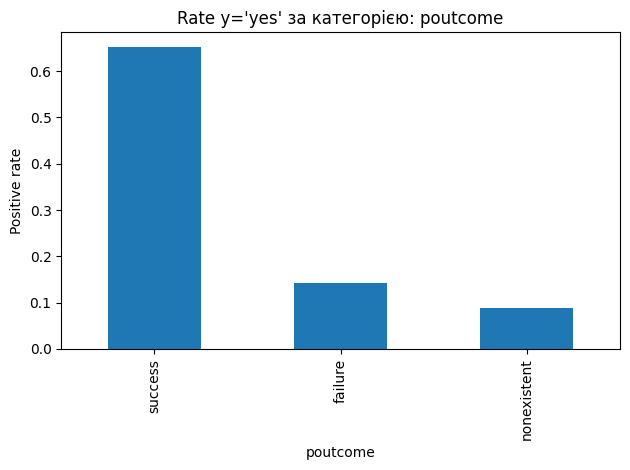

In [101]:
def plot_rate_by_category(df: pd.DataFrame, col: str):
  tmp = (df.groupby(col)['y']
  .apply(lambda s: (s == 'yes').mean())
  .sort_values(ascending=False))
  tmp.plot(kind='bar')
  plt.title(f"Rate y='yes' за категорією: {col}")
  plt.ylabel('Positive rate')
  plt.tight_layout()
  plt.show()

for c in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']:
  if c in df.columns:
    plot_rate_by_category(df, c)

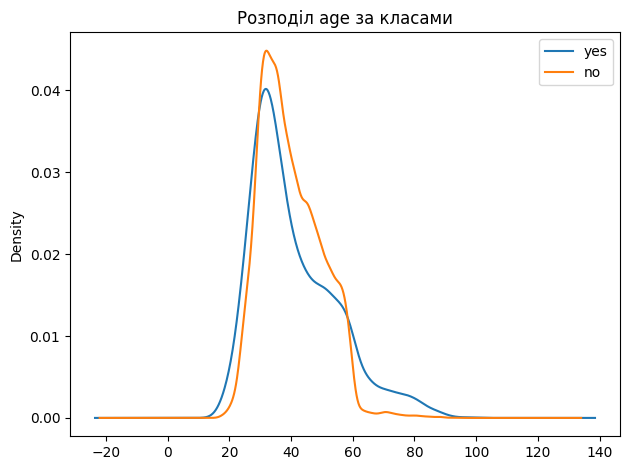

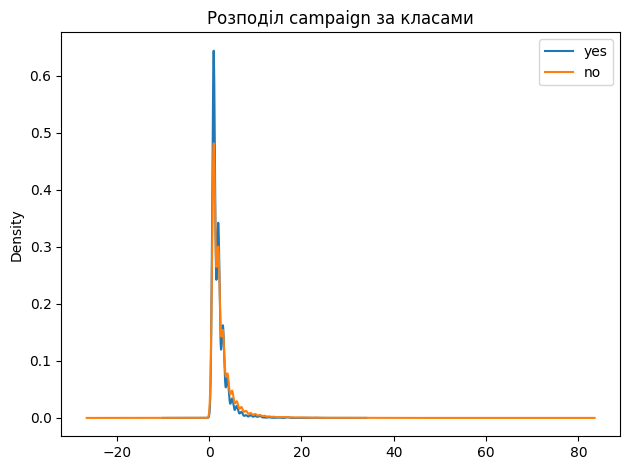

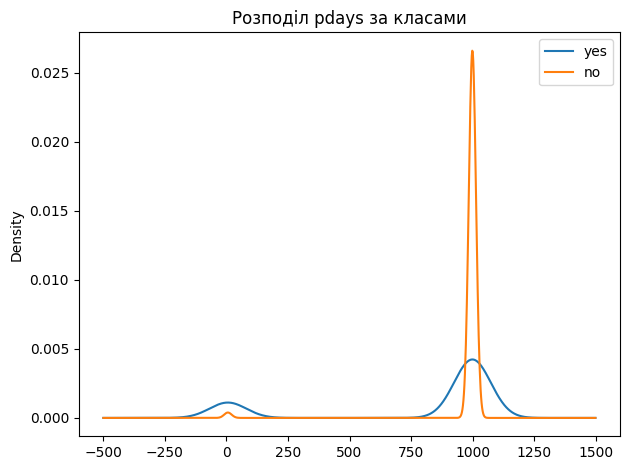

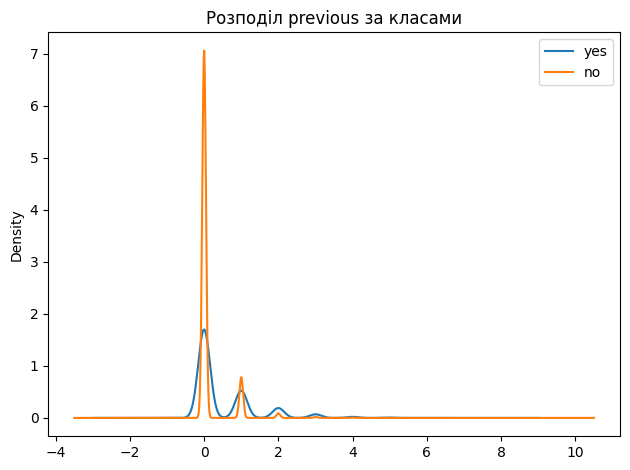

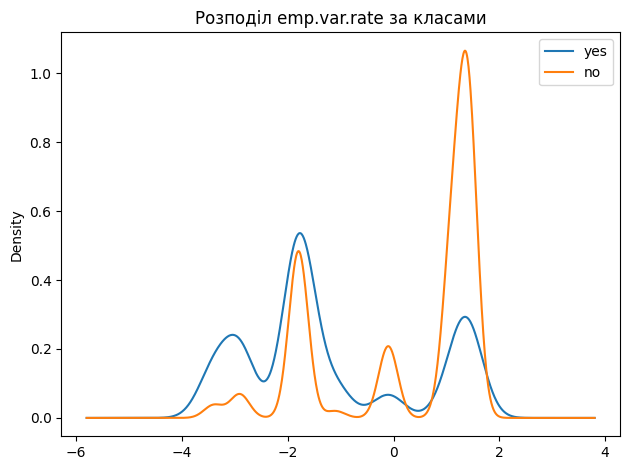

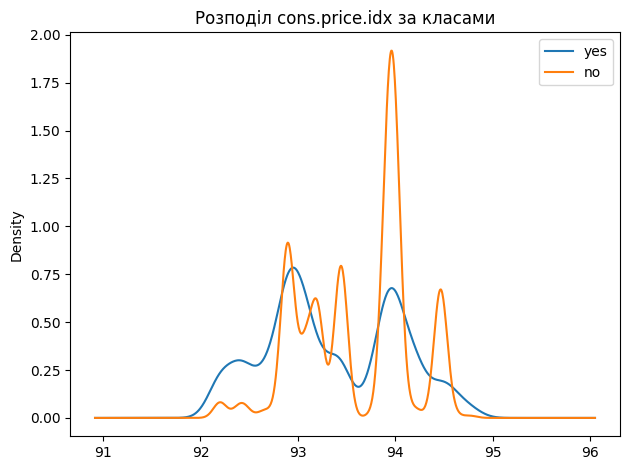

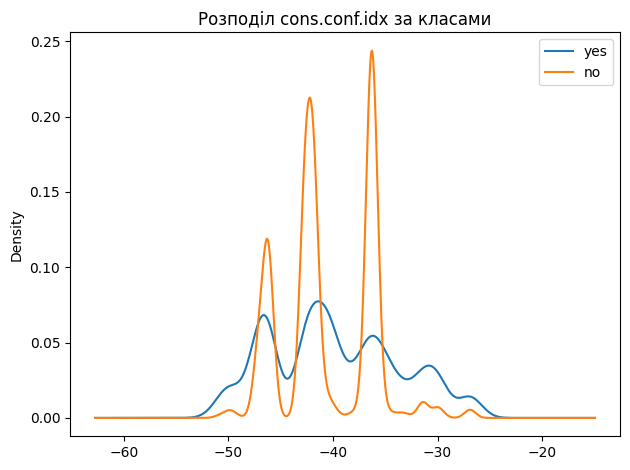

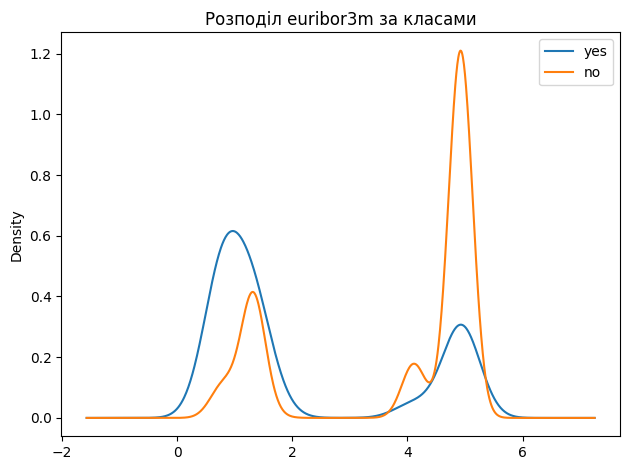

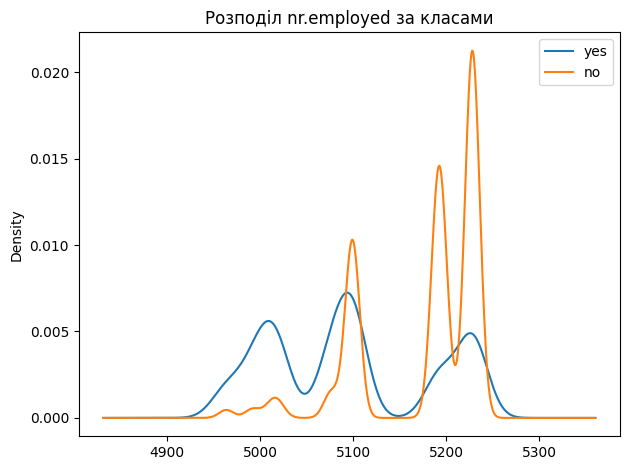

In [102]:
num_cols_raw = [c for c in df.columns if df[c].dtype != 'object' and c != 'duration']
for c in num_cols_raw:
  df_yes = df[df['y']=='yes'][c]
  df_no = df[df['y']=='no'][c]
  df_yes.plot(kind='kde', label='yes')
  df_no.plot(kind='kde', label='no')
  plt.title(f"Розподіл {c} за класами")
  plt.legend()
  plt.tight_layout()
  plt.show()

## preprocesiing 2